In [1]:
%load_ext autoreload
%autoreload 2

# Training as a function of the number of *epochs* (number of samples)

In [2]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from wassa.dataset_generation import sm_generative_model, generate_dataset
from wassa.wassa_plots import plot_results_std, plot_SM, plot_colored_raster
from wassa.wassa_metrics import WassDist, correlation_latent_variables, correlation_kernels, kernels_diff, torch_cdf_loss
from wassa.wassa_utils import performance_as_a_function_of_number_of_epochs

In [3]:
date = '2024-01-20'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 510 # number of timesteps for the raster plot (in ms)
    N_samples = 100 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 1 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 6*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = 1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = 0.1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

## Generative model

Usually I create a $NxD$ kernel to generate spiking motifs. On this kernel (below), probabilities of having a spike are given for each pixel corresponding to a specific adress and a specific delay. 

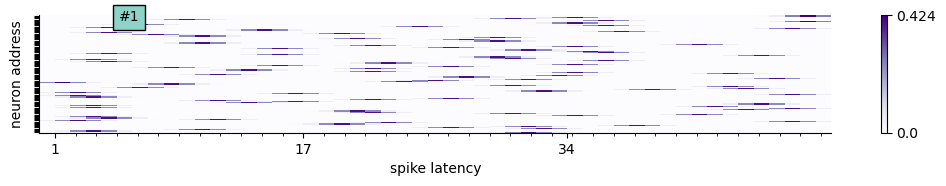

In [5]:
sm = sm_generative_model(dataset_parameters, device = device)
plot_SM(sm.SMs);

Then, I generate trials (equivalent to a recording session) with a duration length ($T$) that can be longer than than the length of the kernel ($D$). There is a frequency of occurence given for the different motifs. See below with $T=10\cdot D=510\;ms$ and frequency of apparition is $6\;Hz$. The motif occurs 2 times and then a totally flat probability distribution represents backgroun activity. Spikes are obtained with Bernoulli trials on each time points of the matric $NxT$ of probability values.

../synthetic_data/synthetic_rp_trainset_50_100_51_1_510_100_100.0_20_6.0_False_1_0_0.1_1_666.pt
../synthetic_data/synthetic_rp_testset_50_100_51_1_510_100_100.0_20_6.0_False_1_0_0.1_1_666.pt


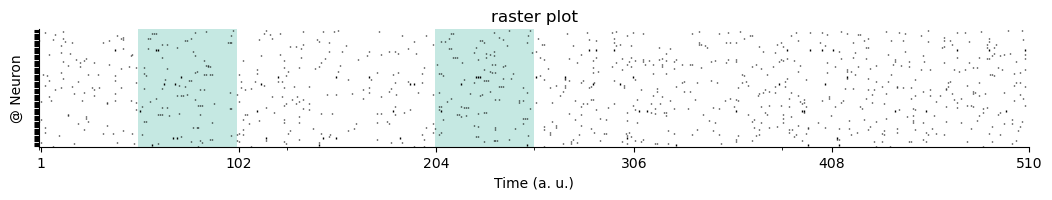

In [6]:
sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, device=device)
random_ind = torch.randint(testset_input.shape[0],[1])
fig_raster, ax_raster = plot_colored_raster(testset_input[random_ind], testset_output[random_ind].cpu().numpy(), dataset_parameters.N_delays);

In this notebook, we want inputs to be equivalent to epochs in SpikeShip, i.e. presentation of a specific motif (Bernoulli trial on the $NxD$ kernel). To check how many epochs are needed for obtaining a good convergence of the autoencoder using MSE or EMD loss for reconstruction. 

Then, $T=D=51\;ms$ and we set the frequency of occurence to $1000\;Hz$ to be sure that a structured motif is presented at each epoch. 

## Condition 1: low jitter (std of 1ms for temporal window od 50ms) - low background activity (10%)

In [7]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 51 # number of timesteps for the raster plot (in ms)
    N_samples = 100 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 1 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 1000*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = 1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = 0.1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

../synthetic_data/synthetic_rp_trainset_50_100_51_1_51_100_100.0_20_1000.0_False_1_0_0.1_1_666.pt
../synthetic_data/synthetic_rp_testset_50_100_51_1_51_100_100.0_20_1000.0_False_1_0_0.1_1_666.pt


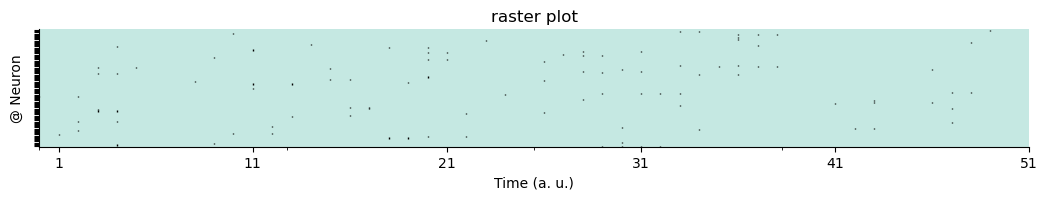

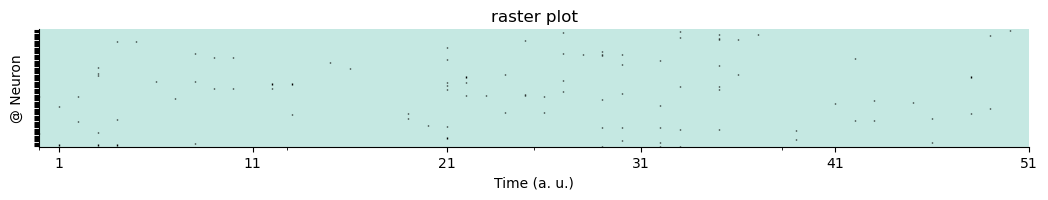

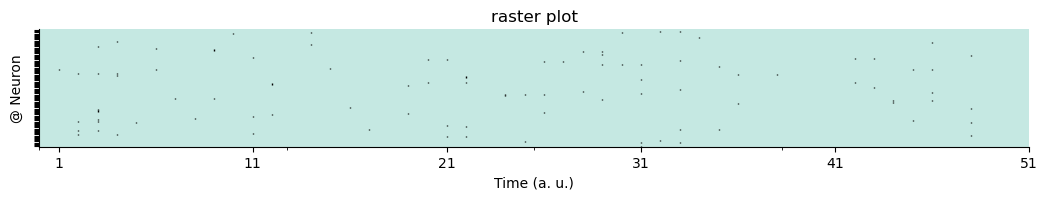

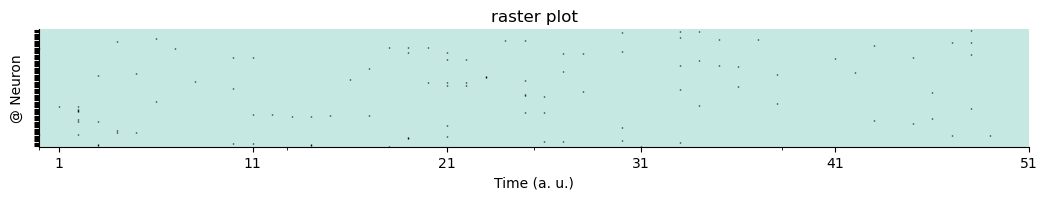

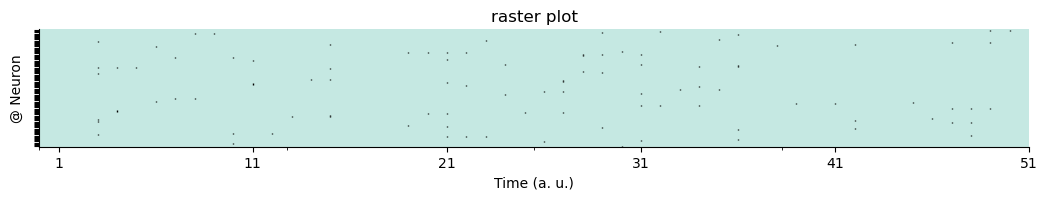

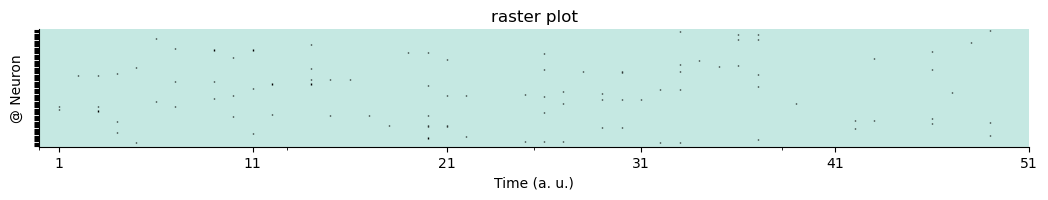

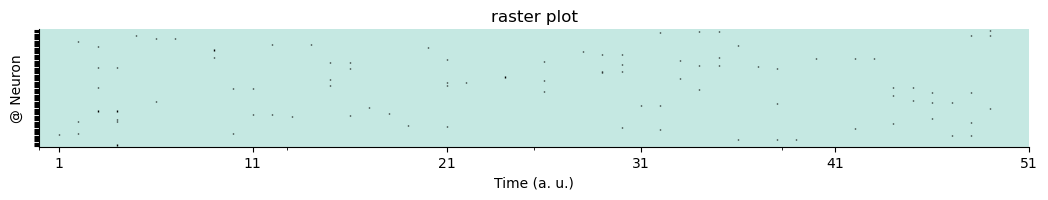

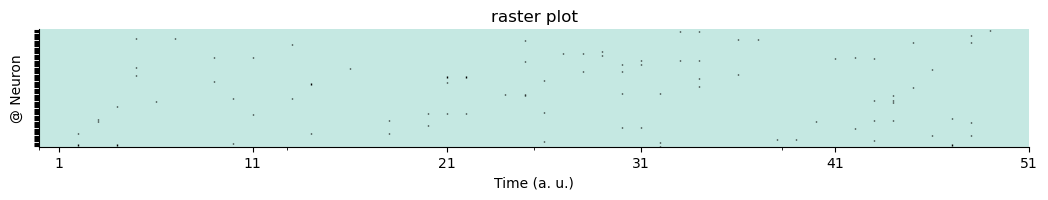

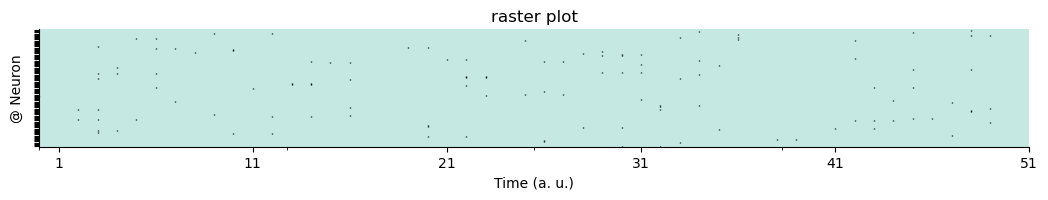

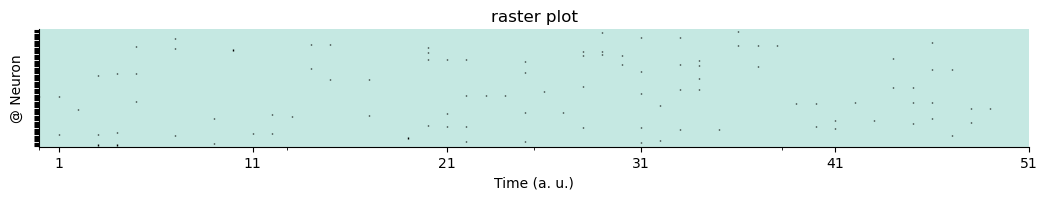

In [8]:
sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, device=device)
for i in range(10):
    random_ind = torch.randint(testset_input.shape[0],[1])
    fig_raster, ax_raster = plot_colored_raster(testset_input[random_ind], testset_output[random_ind].cpu().numpy(), dataset_parameters.N_delays);

Mean absolute difference: 0.006263340823352337


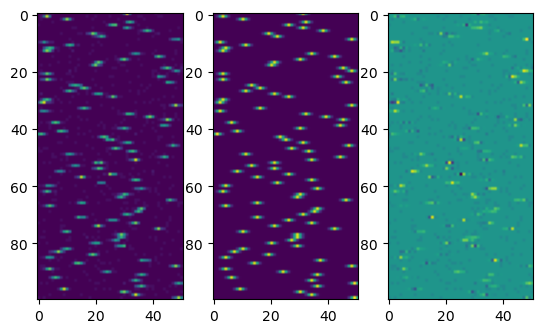

In [9]:
mean_trials = trainset_input.mean(dim=0).cpu()
kernel = sm.SMs[0].cpu()
fig, ax = plt.subplots(1,3)
ax[0].imshow(mean_trials)
ax[1].imshow(kernel)
ax[2].imshow(kernel-mean_trials)
print(f'Mean absolute difference: {(kernel-mean_trials).abs().mean()}')

In [10]:
class training_parameters:
    kernel_size = (sm.opt.N_SMs, sm.opt.N_pre, sm.opt.N_delays)
    loss_type = 'mse'
    N_learnsteps = 1000
    learning_rate = .001
    penalty_type = None
    smoothwind = 20
    lambda_ = .1
    batch_size = None
    output = 'linear'
    do_bias = True
    zeros = 'ignore'
    wass_order = 1
    weight_init = None
    if not penalty_type:
        lambda_ = 0
    elif penalty_type[:8] != 'smoothed':
        smoothwind = 0
    if lambda_ == 0:
        penalty_type = None
    def get_parameters(self):
        name = f'{self.loss_type}_{self.output}_{self.penalty_type}_{self.do_bias}_{self.kernel_size}_{self.N_learnsteps}_{self.learning_rate}_{self.lambda_}_{self.batch_size}_{self.smoothwind}'
        if self.loss_type == 'emd': 
            name += f'_{self.zeros}_{self.wass_order}'
        return name

In [11]:
params_mse = training_parameters()
params_emd = training_parameters()
params_emd.loss_type = 'emd'

In [12]:
N_iter = 20
seeds = torch.arange(0,N_iter)
num_samples = torch.logspace(.5,3,20).int()
results_1, true_epochs = performance_as_a_function_of_number_of_epochs(dataset_parameters, params_emd, params_mse, date, num_samples, seeds = seeds, N_iter=N_iter, device=device)

../results/2024-01-20_performance_as_a_function_of_number_of_epochs_100_51_1_51_1000_100.0_20_1000.0_False_1_0_0.1_1_0_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_3_1000


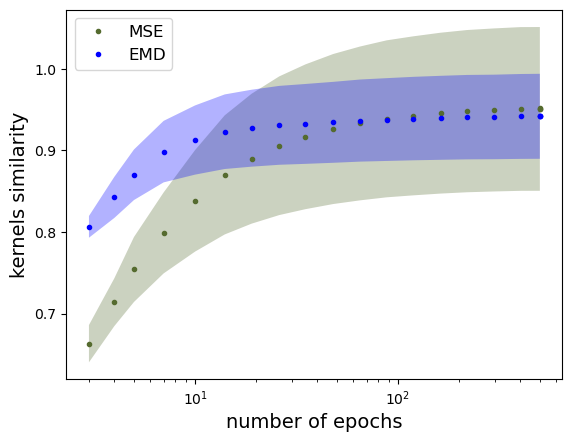

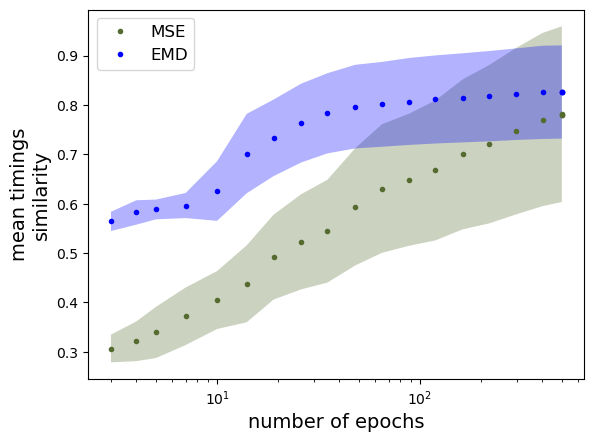

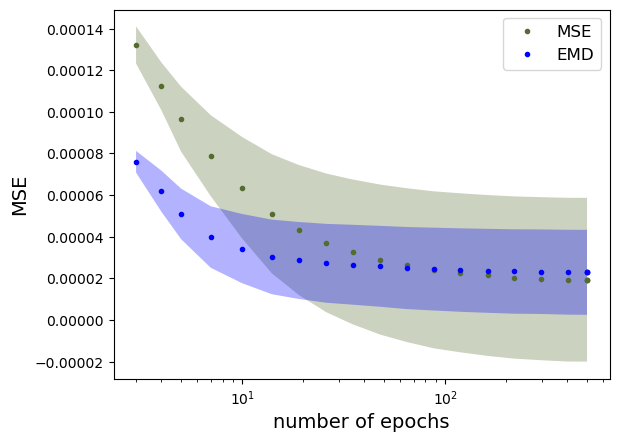

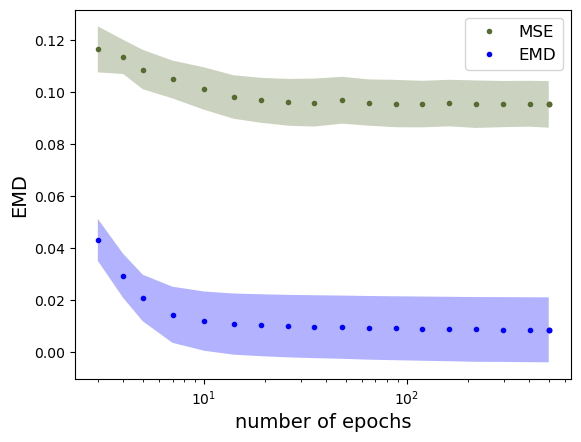

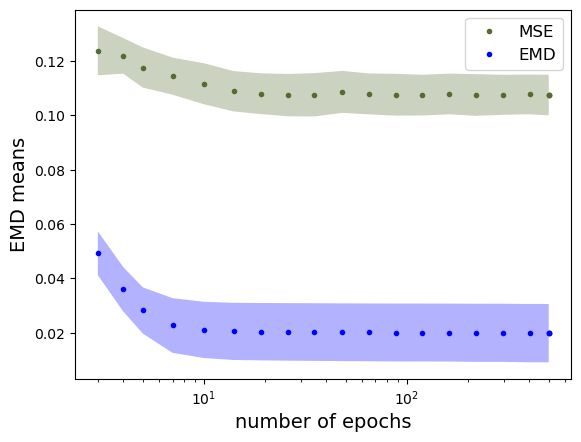

In [13]:
name_metrics = ['kernels similarity', 'mean timings\nsimilarity', 'MSE', 'EMD', 'EMD means']
name_methods = ['MSE', 'EMD']
colors = ['darkolivegreen','blue']
xlabel = 'number of epochs'
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results_1[m,:,:,i],true_epochs,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)

## Condition 2: high jitter (std of 5ms for temporal window of 50ms) - low background activity (10%)

../synthetic_data/synthetic_rp_trainset_500_100_51_1_51_1000_100.0_20_1000.0_False_5_0_0.1_1_0.pt
../synthetic_data/synthetic_rp_testset_500_100_51_1_51_1000_100.0_20_1000.0_False_5_0_0.1_1_0.pt
Mean absolute difference: 0.004296812694519758


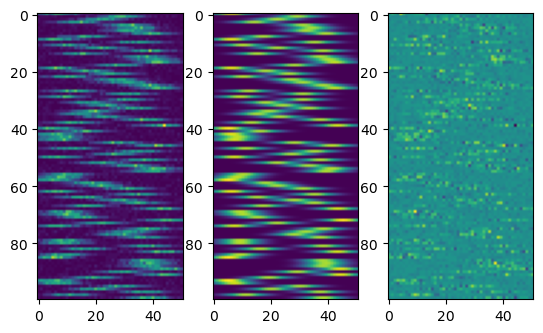

In [14]:
dataset_parameters.temporal_jitter = 5

sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, device=device)
mean_trials = trainset_input.mean(dim=0).cpu()
kernel = sm.SMs[0].cpu()
fig, ax = plt.subplots(1,3)
ax[0].imshow(mean_trials)
ax[1].imshow(kernel)
ax[2].imshow(kernel-mean_trials)
print(f'Mean absolute difference: {(kernel-mean_trials).abs().mean()}')

In [15]:
results_2, true_epochs = performance_as_a_function_of_number_of_epochs(dataset_parameters, params_emd, params_mse, date, num_samples, seeds = seeds, N_iter=N_iter, device=device)

../results/2024-01-20_performance_as_a_function_of_number_of_epochs_100_51_1_51_1000_100.0_20_1000.0_False_5_0_0.1_1_0_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_3_1000


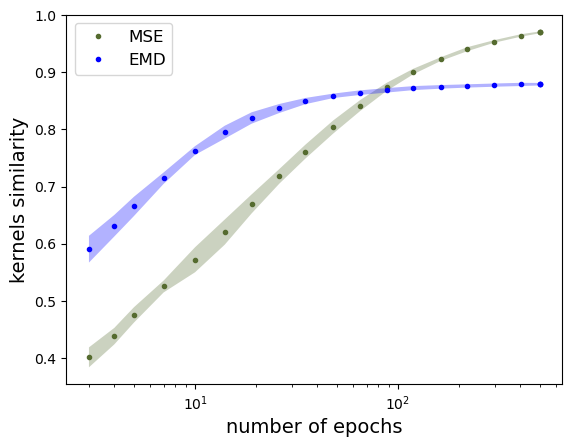

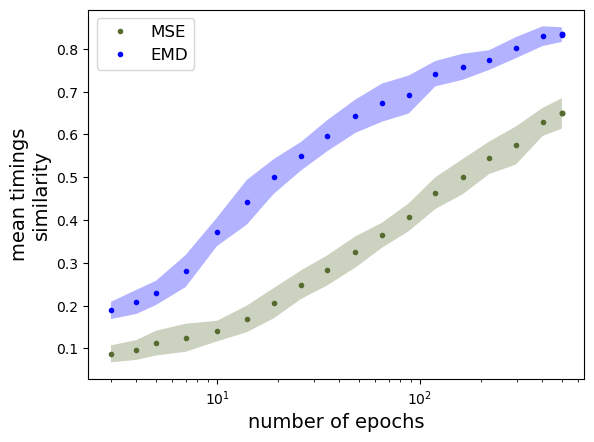

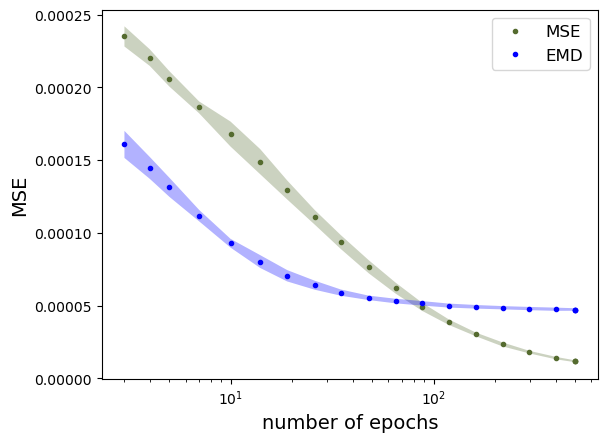

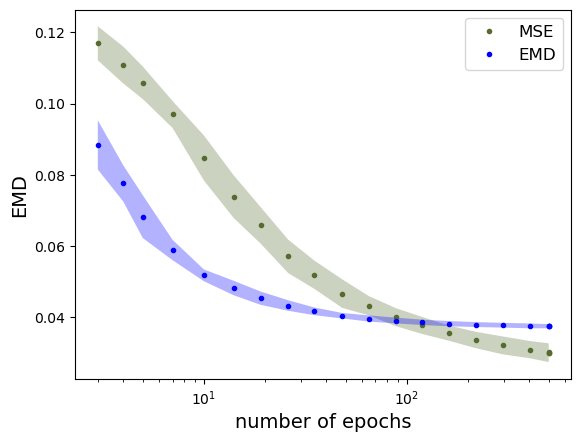

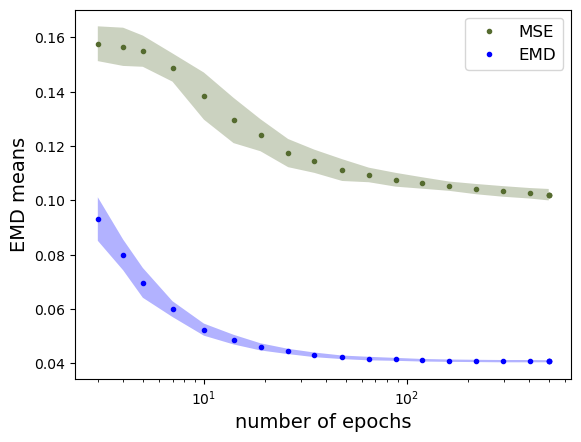

In [16]:
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results_2[m,:,:,i],true_epochs,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)

## Condition 3: high jitter (std of 5ms for temporal window od 50ms) - high background activity (50%)

../synthetic_data/synthetic_rp_trainset_500_100_51_1_51_1000_100.0_20_1000.0_False_5_0_0.5_1_0.pt
../synthetic_data/synthetic_rp_testset_500_100_51_1_51_1000_100.0_20_1000.0_False_5_0_0.5_1_0.pt
Mean absolute difference: 0.012042342685163021


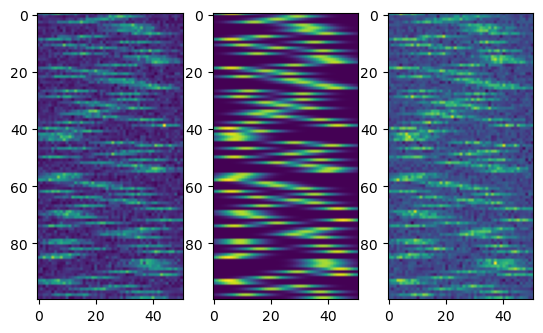

In [17]:
dataset_parameters.additive_noise = .5

sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, device=device)
mean_trials = trainset_input.mean(dim=0).cpu()
kernel = sm.SMs[0].cpu()
fig, ax = plt.subplots(1,3)
ax[0].imshow(mean_trials)
ax[1].imshow(kernel)
ax[2].imshow(kernel-mean_trials)

print(f'Mean absolute difference: {(kernel-mean_trials).abs().mean()}')

In [18]:
results_3, true_epochs = performance_as_a_function_of_number_of_epochs(dataset_parameters, params_emd, params_mse, date, num_samples, seeds = seeds, N_iter=N_iter, device=device)

../results/2024-01-20_performance_as_a_function_of_number_of_epochs_100_51_1_51_1000_100.0_20_1000.0_False_5_0_0.5_1_0_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_3_1000


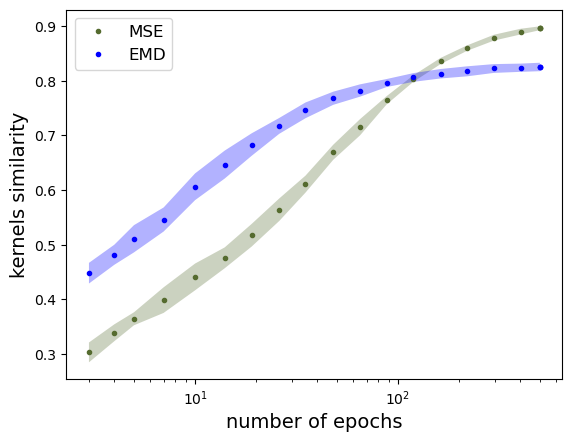

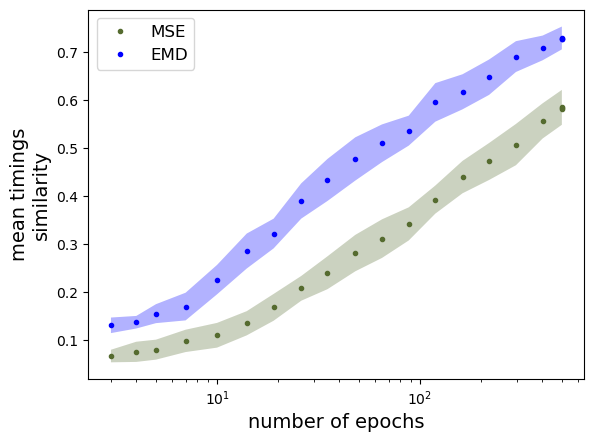

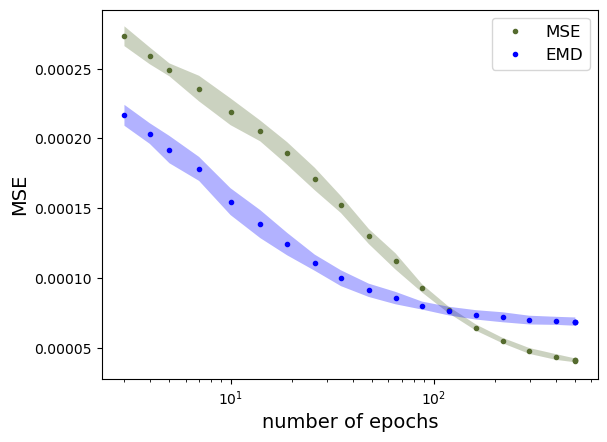

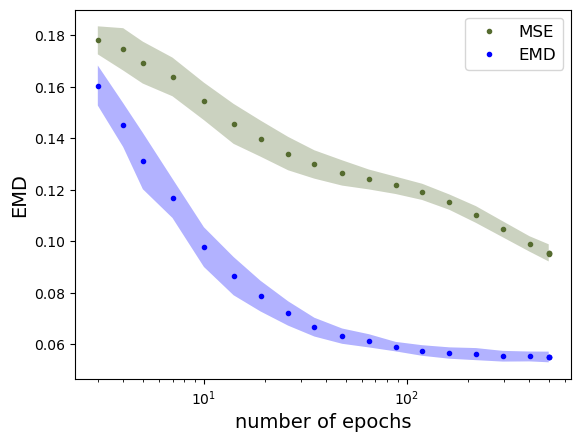

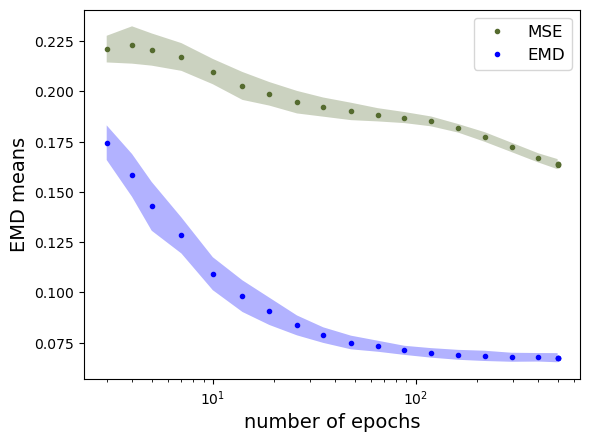

In [19]:
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results_3[m,:,:,i],true_epochs,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)

## Condition 4: low jitter (std of 1ms for temporal window od 50ms) - high background activity (50%)

../synthetic_data/synthetic_rp_trainset_500_100_51_1_51_1000_100.0_20_1000.0_False_1_0_0.5_1_0.pt
../synthetic_data/synthetic_rp_testset_500_100_51_1_51_1000_100.0_20_1000.0_False_1_0_0.5_1_0.pt
Mean absolute difference: 0.017504267394542694


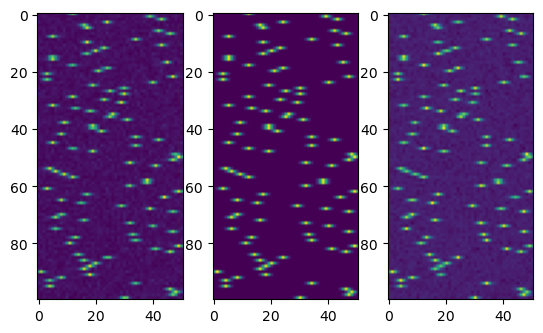

In [20]:
dataset_parameters.temporal_jitter = 1

sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(dataset_parameters, device=device)
mean_trials = trainset_input.mean(dim=0).cpu()
kernel = sm.SMs[0].cpu()
fig, ax = plt.subplots(1,3)
ax[0].imshow(mean_trials)
ax[1].imshow(kernel)
ax[2].imshow(kernel-mean_trials)
print(f'Mean absolute difference: {(kernel-mean_trials).abs().mean()}')

In [21]:
results_4, true_epochs = performance_as_a_function_of_number_of_epochs(dataset_parameters, params_emd, params_mse, date, num_samples, seeds = seeds, N_iter=N_iter, device=device)

../results/2024-01-20_performance_as_a_function_of_number_of_epochs_100_51_1_51_1000_100.0_20_1000.0_False_1_0_0.5_1_0_emd_linear_None_True_(1, 100, 51)_1000_0.001_0_None_20_ignore_1_3_1000


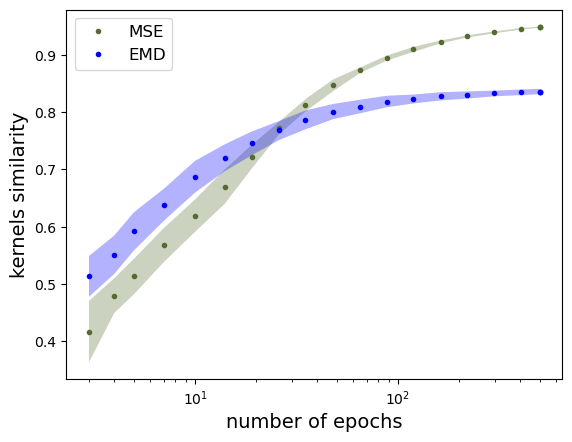

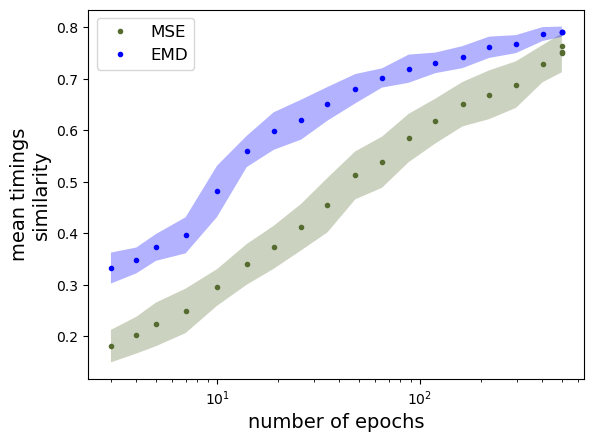

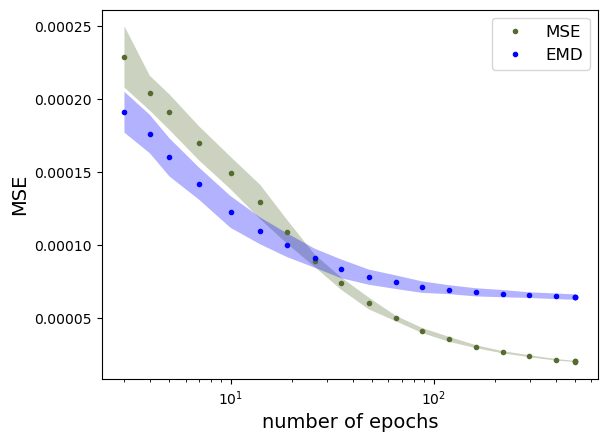

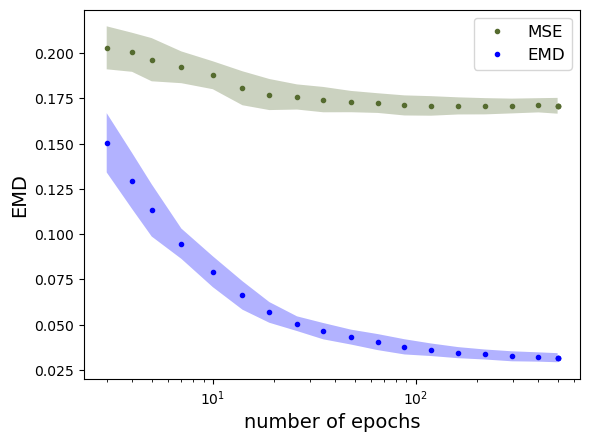

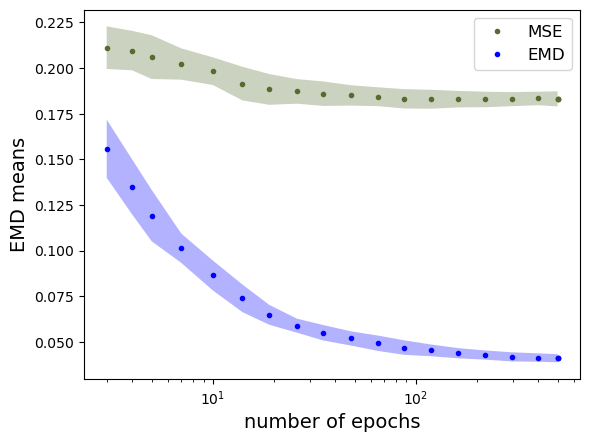

In [22]:
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results_4[m,:,:,i],true_epochs,xlabel,name_metrics[i],name_methods[m],colors[m], logplot=True)

In [23]:
def plot_results_std(ax, results, coefs, xlabel, ylabel, legend, color, ymax=None, ymin=None, logplot=False):
     
    mean_, std_ = results.mean(axis=0), results.std(axis=0)

    if ymin is not None:
        bottom_ = np.maximum(mean_ - std_, ymin*np.ones([len(mean_)]))
    else:
        bottom_ = mean_ - std_
    if ymax is not None:
        top_= np.minimum(mean_ + std_, ymax*np.ones([len(mean_)]))
    else:
        top_ = mean_ + std_

    if logplot:
        ax.semilogx(coefs, mean_, '.',color=color, label=legend)
    else:
        ax.plot(coefs, mean_, '.',color=color, label=legend)
    ax.fill_between(coefs, bottom_, top_, facecolor=color, edgecolor=None, alpha=.3)

    #ax.set_xlabel(xlabel, fontsize=14)
    #ax.set_ylabel(ylabel, fontsize=14)
    #ax.legend(fontsize=12);
    return ax

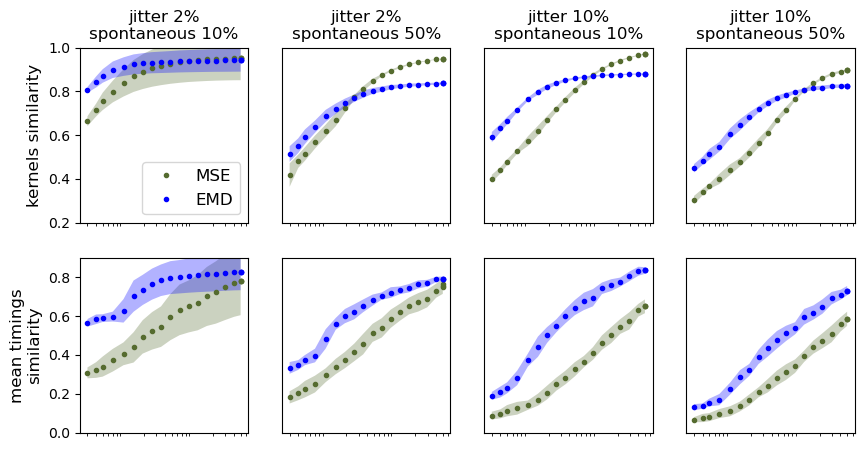

In [24]:
noises = ['jitter 2%\nspontaneous 10%','jitter 2%\nspontaneous 50%','jitter 10%\nspontaneous 10%','jitter 10%\nspontaneous 50%']

results_tot = [results_1,results_4,results_2,results_3]
fontsize = 12
fig, ax = plt.subplots(2,4,figsize=(10,5))
for k in range(4):
    results = results_tot[k]
    for i, ind_m in enumerate(range(2)):
        for m in range(len(name_methods)):
            ax[i,k] = plot_results_std(ax[i,k],results[m,:,:,ind_m],true_epochs,xlabel,name_metrics[ind_m],name_methods[m],colors[m], logplot=True)
            #ax[i,k] = plot_past_results_std(ax[i,k],past_results[m,:,:,ind_m],true_epochs,xlabel,name_metrics[ind_m],name_methods[m],colors[m], logplot=True)
        if i==0: 
            ax[i,k].set_ylim(.2,1)
            ax[i,k].set_title(noises[k])
            if k==0: ax[i,k].legend(fontsize=12, loc='lower right')
        elif i==1: 
            ax[i,k].set_ylim(0,.9)
            #if k<2: ax[i,k].hlines(.75,true_epochs[0],true_epochs[-1],linestyles='dashed',colors='purple')
            #else: ax[i,k].hlines(.35,true_epochs[0],true_epochs[-1],linestyles='dashed',colors='purple', label='ground truth')
        elif i==2: ax[i,k].set_ylim(0,.0003)
        elif i==3: ax[i,k].set_ylim(0,.23)
        if k>0: 
            ax[i,k].set_yticks([])
        else:
            ax[i,k].set_ylabel(name_metrics[ind_m],fontsize=fontsize)
        if i<3:
            ax[i,k].set_xticks([])
        else:
            ax[i,k].set_xlabel('# epochs',fontsize=fontsize)
#fig.savefig(f'{name_metrics[i]}_epochs_{world_parameters.temporal_jitter}_{world_parameters.additive_noise}.pdf')

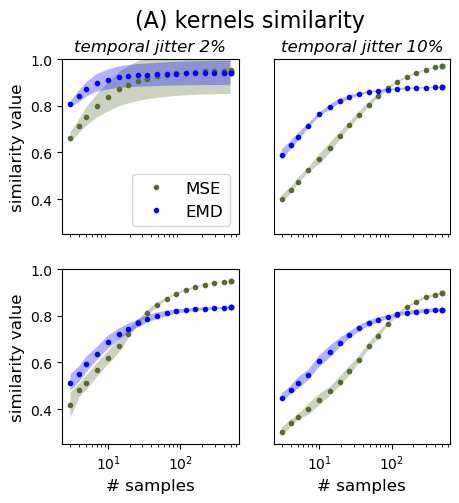

In [25]:
noises = ['jitter 2%\nspontaneous 10%','jitter 2%\nspontaneous 50%','jitter 10%\nspontaneous 10%','jitter 10%\nspontaneous 50%']

jitter_labels = ['temporal jitter 2%','temporal jitter 10%']
additive_labels = ['additive noise 10%','additive noise 50%']
           
results_tot = [results_1,results_2,results_4,results_3]
fontsize = 12
fig, ax = plt.subplots(2,2,figsize=(5,5))

ind_m = 0

for k in range(4):
    results = results_tot[k]
    i = k//2
    j = k-i*2
    for m in range(len(name_methods)):
        ax[i,j] = plot_results_std(ax[i,j],results[m,:,:,ind_m],true_epochs,xlabel,'similarity value',name_methods[m],colors[m], logplot=True)
    if i==0:
        ax[i,j].set_title(jitter_labels[j], style='italic')
        if ind_m:
            ax[i,j].set_ylim(0,.9)
        else:
            ax[i,j].set_ylim(.25,1)
            if k==0: ax[i,k].legend(fontsize=12, loc='lower right')
    elif i==1:
        if ind_m:
            ax[i,j].set_ylim(0,.9)
        else:
            ax[i,j].set_ylim(0.25,1)
        #if k<2: ax[i,k].hlines(.75,true_epochs[0],true_epochs[-1],linestyles='dashed',colors='purple')
        #else: ax[i,k].hlines(.35,true_epochs[0],true_epochs[-1],linestyles='dashed',colors='purple', label='ground truth')
    #elif i==2: ax[i,k].set_ylim(0,.0003)
    #elif i==3: ax[i,k].set_ylim(0,.23)
    if j>0: 
        ax[i,j].set_yticks([])
        if ind_m:
            ax[i,j].text(1, 1, additive_labels[i]+'\n', horizontalalignment='center', verticalalignment='top', rotation=270, style = 'italic', fontsize=fontsize, transform=ax[i,j].transAxes)
    else:
        ax[i,j].set_ylabel('similarity value',fontsize=fontsize)
    if i<1: 
        ax[i,j].set_xticks([])
    else:
        ax[i,j].set_xlabel('# samples',fontsize=fontsize)
if ind_m:
    fig.suptitle('(B) mean timings similarity', fontsize=16);
else:
    fig.suptitle('(A) kernels similarity', fontsize=16);
    
saving = False

if saving:
    fig.tight_layout()
    if ind_m:
        fig.savefig('../figures/results_noises_bias_static_mean_sim.pdf', bbox_inches = 'tight')
    else:
        fig.savefig('../figures/results_noises_bias_static_sim.pdf', bbox_inches = 'tight')